In [0]:
#mlxtendによるアソシエーション分析
! pip install mlxtend

In [0]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.preprocessing import MinMaxScaler
import datetime
import pandas as pd 
import pprint
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np 
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
from google.colab import files
uploaded = files.upload()

Saving BreadBasket_DMS.csv to BreadBasket_DMS.csv


In [4]:
df=pd.read_csv('BreadBasket_DMS.csv')
df.tail(5)

,Date,Time,Transaction,Item
21288,2017-04-09,14:32:58,9682,Coffee
21289,2017-04-09,14:32:58,9682,Tea
21290,2017-04-09,14:57:06,9683,Coffee
21291,2017-04-09,14:57:06,9683,Pastry
21292,2017-04-09,15:04:24,9684,Smoothies


In [5]:
#データ数は21293個
len(df)

21293

In [7]:
#ItemがNoneのデータを削除
df=df.drop(df.loc[df['Item']=='NONE'].index)

#drop後のデータ数は20507個
len(df)

20507

In [21]:
#Itemの種類は94種類
print(len(df["Item"].unique()))
df["Item"].unique()

94


array(['Bread', 'Scandinavian', 'Hot chocolate', 'Jam', 'Cookies',
       'Muffin', 'Coffee', 'Pastry', 'Medialuna', 'Tea', 'Tartine',
       'Basket', 'Mineral water', 'Farm House', 'Fudge', 'Juice',
       "Ella's Kitchen Pouches", 'Victorian Sponge', 'Frittata',
       'Hearty & Seasonal', 'Soup', 'Pick and Mix Bowls', 'Smoothies',
       'Cake', 'Mighty Protein', 'Chicken sand', 'Coke',
       'My-5 Fruit Shoot', 'Focaccia', 'Sandwich', 'Alfajores', 'Eggs',
       'Brownie', 'Dulce de Leche', 'Honey', 'The BART', 'Granola',
       'Fairy Doors', 'Empanadas', 'Keeping It Local', 'Art Tray',
       'Bowl Nic Pitt', 'Bread Pudding', 'Adjustment', 'Truffles',
       'Chimichurri Oil', 'Bacon', 'Spread', 'Kids biscuit', 'Siblings',
       'Caramel bites', 'Jammie Dodgers', 'Tiffin', 'Olum & polenta',
       'Polenta', 'The Nomad', 'Hack the stack', 'Bakewell',
       'Lemon and coconut', 'Toast', 'Scone', 'Crepes', 'Vegan mincepie',
       'Bare Popcorn', 'Muesli', 'Crisps', 'Pintxos', 

In [8]:
#一度に複数の商品購入を考慮すると、総合計Transactionは9465回
df[~df.Transaction.duplicated(keep="first")].count()

Date           9465
Time           9465
Transaction    9465
Item           9465
dtype: int64

In [0]:
############# ここからデータセットの編集 #############

In [9]:
#DateとTimeを結合してdatetime形式でindexにする
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df = df.set_index('DateTime')
df.head()

,Date,Time,Transaction,Item
DateTime,,,,
2016-10-30 09:58:11,2016-10-30,09:58:11,1,Bread
2016-10-30 10:05:34,2016-10-30,10:05:34,2,Scandinavian
2016-10-30 10:05:34,2016-10-30,10:05:34,2,Scandinavian
2016-10-30 10:07:57,2016-10-30,10:07:57,3,Hot chocolate
2016-10-30 10:07:57,2016-10-30,10:07:57,3,Jam


In [10]:
#曜日を設定する

weekday_map = {0: 'Mon',1: 'Tue',2: 'Wed',3: 'Thu',4: 'Fri',5: 'Sat',6: 'Sun'}

df['day_of_the_week'] = df.index.weekday
df['day_of_the_week'] =df.day_of_the_week.map(weekday_map)
df.head()

,Date,Time,Transaction,Item,day_of_the_week
DateTime,,,,,
2016-10-30 09:58:11,2016-10-30,09:58:11,1,Bread,Sun
2016-10-30 10:05:34,2016-10-30,10:05:34,2,Scandinavian,Sun
2016-10-30 10:05:34,2016-10-30,10:05:34,2,Scandinavian,Sun
2016-10-30 10:07:57,2016-10-30,10:07:57,3,Hot chocolate,Sun
2016-10-30 10:07:57,2016-10-30,10:07:57,3,Jam,Sun


In [11]:
#購入された時間帯の区別を新しいcolumnに入れる

df["time_range"] = df.Time.apply(lambda x: x[:2])
df.head()

,Date,Time,Transaction,Item,day_of_the_week,time_range
DateTime,,,,,,
2016-10-30 09:58:11,2016-10-30,09:58:11,1,Bread,Sun,09
2016-10-30 10:05:34,2016-10-30,10:05:34,2,Scandinavian,Sun,10
2016-10-30 10:05:34,2016-10-30,10:05:34,2,Scandinavian,Sun,10
2016-10-30 10:07:57,2016-10-30,10:07:57,3,Hot chocolate,Sun,10
2016-10-30 10:07:57,2016-10-30,10:07:57,3,Jam,Sun,10


In [12]:
#それぞれの商品が特定の曜日、時間帯で何回購入されたかを新しいcolumnに入れる

df["time_range_total_sales"] = None
week=['Mon','Tue','Wed','Thu','Fri','Sat','Sun']

for item in df["Item"].unique():
    for i in week:
        transaction_count = df[(df["Item"]==item) & (df["day_of_the_week"]==i)].groupby('time_range').Transaction.count()
        df.loc[(df["day_of_the_week"]==i)&(df["Item"]==item),["time_range_total_sales"]] = df.loc[(df["day_of_the_week"]==i)&(df["Item"]==item)].time_range.map(transaction_count)

df.head()

,Date,Time,Transaction,Item,day_of_the_week,time_range,time_range_total_sales
DateTime,,,,,,,
2016-10-30 09:58:11,2016-10-30,09:58:11,1,Bread,Sun,09,28
2016-10-30 10:05:34,2016-10-30,10:05:34,2,Scandinavian,Sun,10,7
2016-10-30 10:05:34,2016-10-30,10:05:34,2,Scandinavian,Sun,10,7
2016-10-30 10:07:57,2016-10-30,10:07:57,3,Hot chocolate,Sun,10,16
2016-10-30 10:07:57,2016-10-30,10:07:57,3,Jam,Sun,10,8


In [0]:
########### ここからはデータセットを要素に分解して分析

In [13]:
#単品で購入されているものトップ10

df[~df.Transaction.duplicated(keep=False)].Item.value_counts().head(10)

Bread            1122
Coffee           1008
Farm House        199
Tea               188
Scandinavian      113
Cake               95
Baguette           64
Sandwich           61
Hot chocolate      61
Pastry             60
Name: Item, dtype: int64

In [14]:
#時間帯別のTransaction数

total_transaction_list = []
for i in range(0,24):
    total_transaction = df[df["time_range"]=="{:0>2d}".format(i)].Item.count()
    total_transaction_list.append(total_transaction)
    print ("{:0>2d}時 : ".format(i),total_transaction)

00時 :  0
01時 :  1
02時 :  0
03時 :  0
04時 :  0
05時 :  0
06時 :  0
07時 :  24
08時 :  645
09時 :  1966
10時 :  2666
11時 :  3102
12時 :  2854
13時 :  2617
14時 :  2640
15時 :  2115
16時 :  1343
17時 :  368
18時 :  82
19時 :  48
20時 :  22
21時 :  3
22時 :  8
23時 :  3


<BarContainer object of 24 artists>

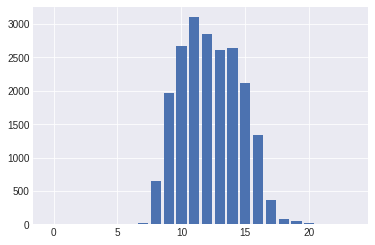

In [15]:
plt.style.use('seaborn-deep')
plt.style.use('seaborn-darkgrid')
plt.bar([i for i in range(24)], total_transaction_list, align="center")

In [16]:
#各時間帯に購入される商品トップ５を抽出

top5_index_value_at_time = dict()

for i in range(7,20):
    top5_data = df[df["time_range"]=="{:0>2d}".format(i)].Item.value_counts().head()
    top5_lists = ["{} ({})".format(i,z) for i,z in zip(top5_data.index,top5_data.values)]
    top5_index_value_at_time ["{:0>2d}".format(i)] = top5_lists

pd.DataFrame([i for i in top5_index_value_at_time .values()], index=["{:0>2d}".format(i)  for i in range(7,20)],columns=list('12345'))


,1,2,3,4,5
07,Coffee (13),Medialuna (6),Pastry (2),Bread (2),Toast (1)
08,Coffee (199),Bread (171),Pastry (57),Medialuna (43),Toast (23)
09,Coffee (583),Bread (400),Pastry (191),Medialuna (120),Tea (103)
10,Coffee (820),Bread (508),Pastry (203),Tea (156),Medialuna (125)
11,Coffee (946),Bread (528),Tea (176),Pastry (151),Cake (133)
12,Coffee (740),Bread (474),Tea (183),Sandwich (162),Cake (127)
13,Coffee (607),Bread (340),Sandwich (234),Tea (181),Cake (124)
14,Coffee (636),Bread (341),Tea (233),Cake (182),Sandwich (171)
15,Coffee (519),Bread (310),Tea (207),Cake (174),Hot chocolate (89)
16,Coffee (321),Bread (196),Tea (126),Cake (124),Hot chocolate (71)


In [17]:
#曜日別にItemの売れ行きをみる

from collections import OrderedDict
 
weekday_map = {0: 'Mon',1: 'Tue',2: 'Wed',3: 'Thu',4: 'Fri',5: 'Sat',6: 'Sun'}
top5_index_value_at_time = OrderedDict()

for i in range(7):
    top5_data = df[df["day_of_the_week"]=="{}".format(weekday_map[i])].Item.value_counts().head()
    top5_lists = ["{} ({})".format(i,z) for i,z in zip(top5_data.index,top5_data.values)]
    top5_index_value_at_time ["{:0>2d}".format(i)] = top5_lists

pd.DataFrame([i for i in top5_index_value_at_time .values()], index=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'],columns=list('12345'))



,1,2,3,4,5
Mon,Coffee (681),Bread (360),Tea (193),Pastry (105),Sandwich (101)
Tue,Coffee (710),Bread (350),Tea (194),Cake (139),Pastry (119)
Wed,Coffee (628),Bread (405),Tea (188),Cake (123),Pastry (103)
Thu,Coffee (670),Bread (450),Tea (183),Cake (141),Pastry (121)
Fri,Coffee (854),Bread (527),Tea (218),Sandwich (134),Cake (120)
Sat,Coffee (1103),Bread (760),Tea (288),Cake (246),Pastry (166)
Sun,Coffee (825),Bread (473),Tea (171),Cake (167),Medialuna (134)


In [0]:
#グラフ化前処理

weekday_map = {'Mon':0,'Tue':1,'Wed':2,'Thu':3,'Fri':4,'Sat':5,'Sun':6}
df['day_of_the_week'] =df.day_of_the_week.map(weekday_map)
df['time_range'] =df.time_range.apply(lambda x: int(x))

In [0]:

def to_int(x):
    scaler = MinMaxScaler(feature_range=(150, 1500))
    x = x.astype(np.int64)
    global max_label
    max_label = int(np.max(x)) 
    x = scaler.fit_transform(x.reshape(-1,1))
    
    return x


def show_item_graph(x):
    
    item_name = str(x)

    fig, ax=plt.subplots(figsize=(12,10))
    plt.style.use('seaborn-deep')
    plt.style.use('seaborn-darkgrid')
    plt.rcParams['font.family'] = "AppleGothic"

    plt.tick_params(labelsize=16)
    plt.tick_params(labelbottom=False)
    plt.ylabel('Time',fontsize=18)
    plt.ylim([7.2,20])
    title = "{} sales".format(item_name)
    plt.title(title, ha='center',y=1.03,fontsize=23)

    ax.text(0,6.7, 'Mon', fontsize=15,horizontalalignment='center')
    ax.text(1,6.7, 'Tue', fontsize=15,horizontalalignment='center')
    ax.text(2,6.7, 'Wed', fontsize=15,horizontalalignment='center')
    ax.text(3,6.7, 'Thu', fontsize=15,horizontalalignment='center')
    ax.text(4,6.7, 'Fri', fontsize=15,horizontalalignment='center')
    ax.text(5,6.7, 'Sat', fontsize=15,horizontalalignment='center')
    ax.text(6,6.7, 'Sun', fontsize=15,horizontalalignment='center')

    plt.rcParams["legend.facecolor"] = 'red'

    plt.scatter(x='day_of_the_week', y='time_range', s=to_int(df[df["Item"]==item_name].time_range_total_sales.values),
                data=df[df["Item"]==item_name],alpha=0.4)
    
    textstr = 'Max circle = {}'.format(max_label)
    textstr2 = '{} - {}'.format(min(df["Date"]).replace('-', '/'),max(df["Date"]).replace('-', '/'))
    ax.text(0.99, 0.98, textstr, transform=ax.transAxes, fontsize=13,
            verticalalignment='top', horizontalalignment='right', bbox=None)
    ax.text(0.99, 1.04, textstr2, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', horizontalalignment='right', bbox=None)

    plt.tight_layout()
    #plt.savefig('image.png')
    plt.show()
    

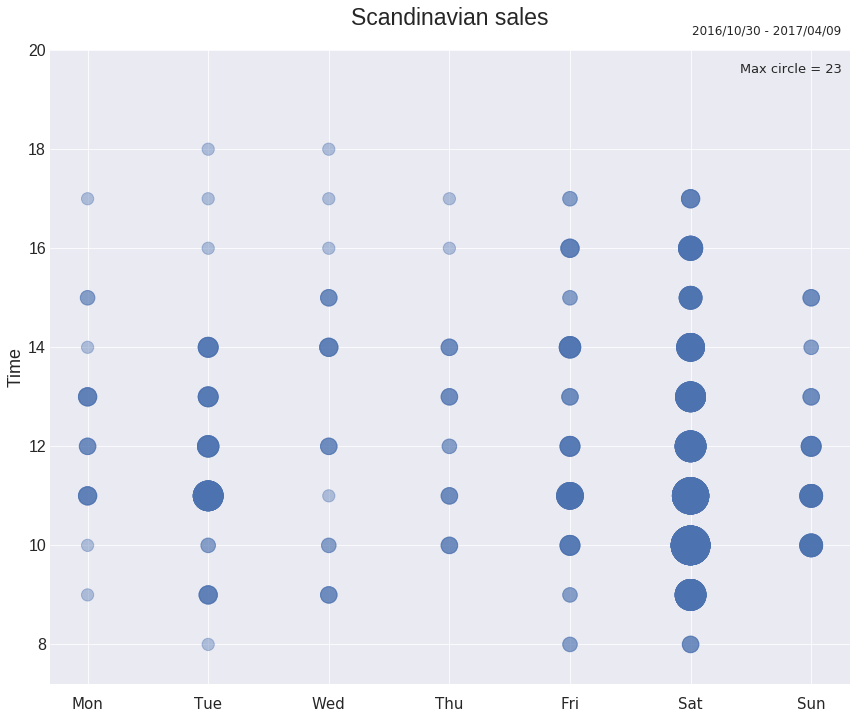

In [20]:
#各Itemの曜日･時間帯別データをグラフ化

show_item_graph("Scandinavian")